# SoundMap Music Recommendation (Based on CNN Classification)

## I. Data Preprocessing

#### Project **SoundMap** ([Github](https://github.com/hojungcho/SoundMap))
Audio Analysis & AI Modeling - Jeeho Lim


## Overview
We use the `fma_small` subset of the [Free Music Archive (FMA) dataset](https://github.com/mdeff/fma) for data preprocessing to train a **music genre classification model**. The FMA dataset contains thousands of audio tracks and metadata (e.g., genres, artist information). Using this dataset, we will generate **Mel Spectrograms** and train a **Convolutional Neural Network (CNN)** model using these spectrograms.

### Introduction to the FMA Dataset
- The dataset is available in different sizes: **fma_small (8,000 tracks)**, **fma_medium (25,000 tracks)**, and **fma_large (106,000 tracks)**.
- Each track includes metadata such as genre and artist information, which we will use to label the tracks.

### Preprocessing Steps
To prepare the data for model training, the following steps are performed:
1. **Mel Spectrogram Generation**: We convert mp3 files into Mel Spectrograms using the `librosa` library. Mel Spectrograms visualize the time-frequency information of the audio, transforming it into an image format that CNN models can learn from.
   
2. **Spectrogram Slicing**: The generated spectrograms are sliced into **smaller patches (128x128 pixels)**. This slicing helps the model learn small patterns within the spectrogram and generates more training data.

3. **Dataset Splitting**: The sliced spectrogram images and genre information are used to split the data into training and testing sets. Metadata from FMA is utilized to label each track with its genre.

4. **Final Output**: The preprocessed data is saved as **numpy** arrays, ready for model training.

- Upon completing this preprocessing, we obtain training and testing datasets containing **Mel Spectrogram** images and labels. These datasets will be used to train a music genre classification model. 
- After the model is trained, we will extract latent feature vectors and build a recommendation system based on cosine similarity to suggest songs with similar characteristics.

### Requirements

- Python==3.11.5
- pandas==2.0.3 
- numpy==1.24.3 
- librosa==0.10.2.post1 
- matplotlib==3.7.2
- Pillow (PIL)==9.4.0 
- scikit-learn==1.3.0

### 1. Import Libraries

In [1]:
import os
import re
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [2]:
# Mel Spectrogram generation function with resizing to 224x224
def create_spectrogram(folder_sample, metadata_file, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Load metadata
    tracks = pd.read_csv(metadata_file, header=2, low_memory=False)
    tracks_id_array = tracks.iloc[:, 0].values
    tracks_genre_array = tracks.iloc[:, 40].values

    directories = [d for d in os.listdir(folder_sample) if os.path.isdir(os.path.join(folder_sample, d))]

    # Count the total number of mp3 files
    total_files = sum(len(files) for _, _, files in os.walk(folder_sample) if any(f.endswith(".mp3") for f in files))
    
    # Check the list of already generated spectrogram files
    existing_files = set(os.listdir(save_folder)) if os.path.exists(save_folder) else set()
    generated_tracks = {int(re.search(r'(\d+)_.*\.jpg', f).group(1)) for f in existing_files}

    print("Starting or resuming spectrogram generation...")
    
    with tqdm(total=total_files, desc="Generating Spectrograms", unit="file") as pbar:
        for d in directories:
            label_directory = os.path.join(folder_sample, d)
            file_names = [os.path.join(label_directory, f) for f in os.listdir(label_directory) if f.endswith(".mp3")]

            for f in file_names:
                track_id = int(re.search(r'fma_small/.*/(.+?).mp3', f).group(1))
                
                # Skip already processed tracks
                if track_id in generated_tracks:
                    pbar.update(1)
                    continue
                
                try:
                    track_index = np.where(tracks_id_array == track_id)[0][0]
                except IndexError:
                    pbar.update(1)
                    continue

                genre = str(tracks_genre_array[track_index])

                # Check if the spectrogram file already exists
                save_path = f"{save_folder}/{track_id}_{genre}.jpg"
                if os.path.exists(save_path):
                    pbar.update(1)
                    continue

                if genre != '0':  # Process tracks with non-zero genre labels
                    try:
                        y, sr = librosa.load(f)
                    except Exception as e:
                        pbar.update(1)
                        continue

                    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
                    mel_db = librosa.power_to_db(mel_spectrogram)

                    plt.figure(figsize=(mel_db.shape[1] / 100, mel_db.shape[0] / 100))
                    plt.axis('off')
                    librosa.display.specshow(mel_db, cmap='gray_r')
                    temp_save_path = f"{save_folder}/temp_{track_id}.jpg"
                    plt.savefig(temp_save_path, dpi=100, bbox_inches='tight', pad_inches=0)
                    plt.close()

                    # Resize the saved image to 224x224
                    with Image.open(temp_save_path) as img:
                        img_resized = img.resize((224, 224))
                        img_resized.save(save_path)
                    os.remove(temp_save_path)

                pbar.update(1)


In [3]:
# Execute preprocessing with resizing
metadata_file = 'fma_metadata/tracks.csv'
folder_sample = 'fma_small'
spectrogram_folder = 'Train_Spectrogram_Images_224'

create_spectrogram(folder_sample, metadata_file, spectrogram_folder)

Starting or resuming spectrogram generation...


Generating Spectrograms:   3%|▎           | 248/7991 [00:00<00:21, 368.19file/s][src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
Generating Spectrograms: 100%|███████████▉| 7990/7991 [02:00<00:00, 66.27file/s]


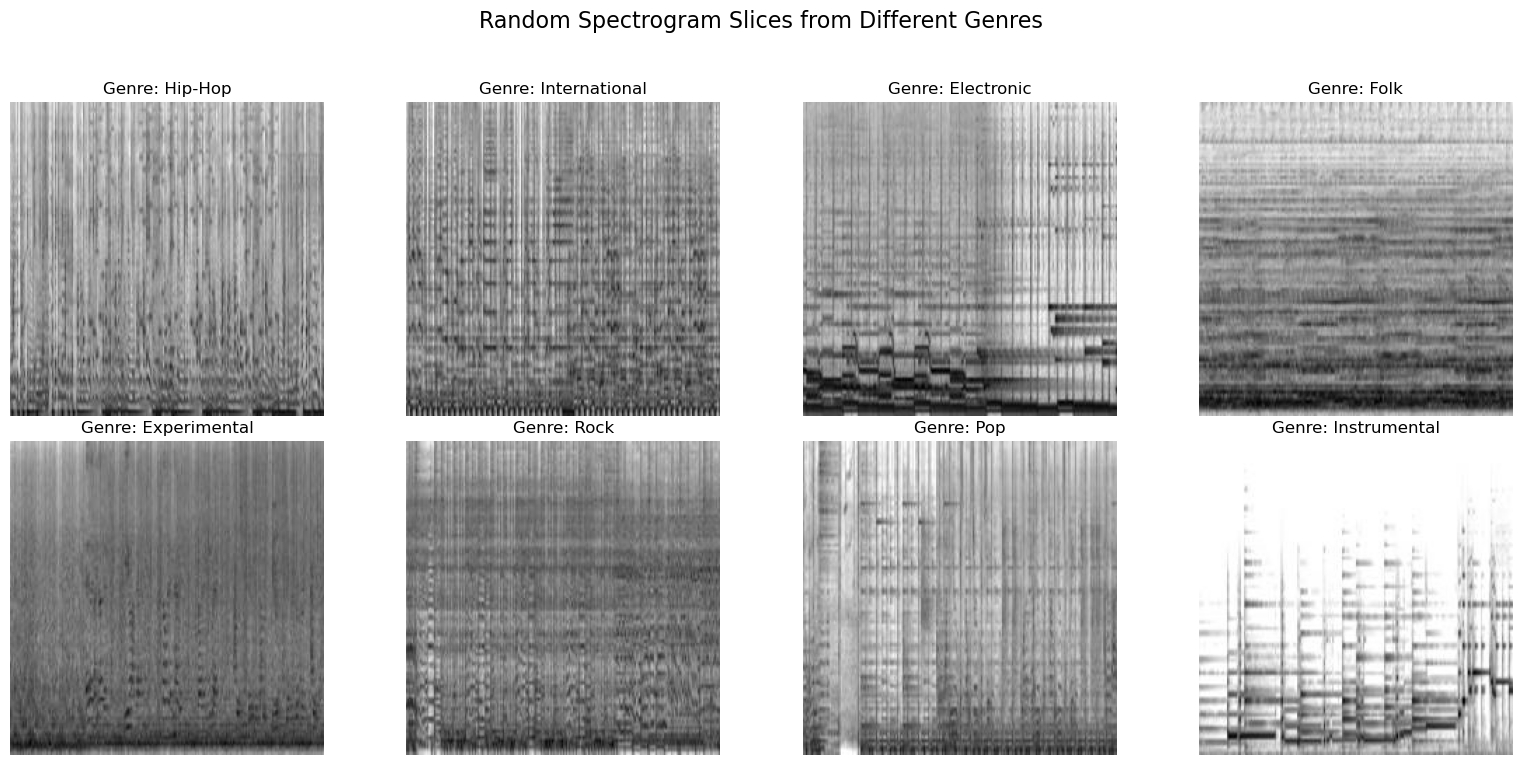

In [6]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

# Function to display random resized spectrograms from each genre
def display_random_slices(slice_folder):
    genre_map = {"Hip-Hop": 0, "International": 1, "Electronic": 2, "Folk": 3, 
                 "Experimental": 4, "Rock": 5, "Pop": 6, "Instrumental": 7}
    genre_files = {genre: [] for genre in genre_map.keys()}
    
    # Collect files by genre
    for f in os.listdir(slice_folder):
        if f.endswith(".jpg"):
            genre = re.search(r'.*_(.+?).jpg', f).group(1)
            if genre in genre_files:
                genre_files[genre].append(f)
    
    # Randomly select one file from each genre (if available)
    selected_files = []
    for genre, files in genre_files.items():
        if files:  # Check if there are files available for the genre
            selected_files.append(random.choice(files))
    
    # Plot the selected files in a 4x2 grid
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Random Spectrogram Slices from Different Genres', fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(selected_files):
            file = selected_files[i]
            genre = re.search(r'.*_(.+?).jpg', file).group(1)
            img = Image.open(os.path.join(slice_folder, file))
            img = img.resize((224, 224))  # Resize the image to 224x224 for consistency
            ax.imshow(img)
            ax.set_title(f"Genre: {genre}")
            ax.axis('off')
        else:
            ax.axis('off')  # Hide any extra subplots if there are not enough genres

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the function to display random slices
spectrogram_folder = 'Train_Spectrogram_Images_224'  # Update with the correct folder name
display_random_slices(spectrogram_folder)


In [5]:
# Load dataset and split function
def load_dataset(slice_folder, dataset_size=1.0):
    genre_map = {"Hip-Hop": 0, "International": 1, "Electronic": 2, "Folk": 3, "Experimental": 4, "Rock": 5, "Pop": 6, "Instrumental": 7}
    filenames = [os.path.join(slice_folder, f) for f in os.listdir(slice_folder) if f.endswith(".jpg")]
    images, labels = [], []

    for f in filenames:
        genre = re.search(r'.*_(.+?).jpg', f).group(1)
        img = Image.open(f).convert('L')
        images.append(np.array(img))
        labels.append(genre_map[genre])

    images, labels = np.array(images), np.array(labels).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(images, labels, test_size=0.05, shuffle=True)
    os.makedirs('224_Training_Data', exist_ok=True)
    np.save('224_Training_Data/train_x.npy', train_x)
    np.save('224_Training_Data/train_y.npy', train_y)
    np.save('224_Training_Data/test_x.npy', test_x)
    np.save('224_Training_Data/test_y.npy', test_y)
    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = load_dataset(spectrogram_folder)

print(f"Train data shape: {train_x.shape}")

Train data shape: (7587, 224, 224)
